**Importing** **Libraries**

In [1]:
#misc
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# preprocessing imports
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords

#visuals
import matplotlib.pyplot as plt #simple colors 
from wordcloud import WordCloud

**Data Exploration**

In [4]:
df = pd.read_csv("validated_8625_data_propublica.csv")
df.head()

,article_link,title,author,author_link,article_content,date_published,content_type,word length
0,https://www.propublica.org/article/rent-limits...,Rent Limits Just a Fiction for Thousands of NY...,"Cezary Podkul, Marcelo Rochabrun",https://www.propublica.org/people/cezary-podku...,About 28 percent of New York City apar...,2016-03-10T12:58:06-05:00,article,898
1,https://www.propublica.org/article/federal-jud...,Federal Judge Strikes Down Part of Montana’s F...,Marilyn W. Thompson,https://www.propublica.org/people/marilyn-thom...,"In a victory for public health advocates, a f...",2022-12-12T17:00:00-05:00,article,601
2,https://www.propublica.org/article/hrs-2011-sl...,Photos: The Doctor Will See Them Now,ProPublica,https://www.propublica.org/people/propublica,The Heart Rhythm Society held its 2011 confere...,2011-05-06T09:04:00-04:00,article,113
3,https://www.propublica.org/article/government-...,Government Does Not Test for Dangerous Bacteri...,Joaquin Sapien,https://www.propublica.org/people/joaquin-sapien,"Despite evidence that MRSA, an antibio...",2008-06-11T09:58:00-04:00,article,195
4,https://www.propublica.org/article/the-man-beh...,The Man Behind Mumbai,Sebastian Rotella,https://www.propublica.org/people/sebastian-ro...,This article was copublished with the ...,2010-11-13T21:39:17-05:00,article,4285


In [5]:
df.shape

(8625, 8)

In [10]:
df.describe(exclude='number')

,article_link,title,author,author_link,article_content,date_published,content_type
count,8625,8625,8625,8625,8625,8625,8625
unique,8625,8625,1038,1042,8625,8457,4
top,https://www.propublica.org/article/rent-limits...,Rent Limits Just a Fiction for Thousands of NY...,Marian Wang,https://www.propublica.org/people/marian-wang,About 28 percent of New York City apar...,2021-06-08 04:59:00-04:00,article
freq,1,1,536,536,1,4,8331


In [7]:
df.isna().sum()

article_link       0
title              0
author             0
author_link        0
article_content    0
date_published     0
content_type       0
word length        0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8625 entries, 0 to 8624
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_link     8625 non-null   object
 1   title            8625 non-null   object
 2   author           8625 non-null   object
 3   author_link      8625 non-null   object
 4   article_content  8625 non-null   object
 5   date_published   8625 non-null   object
 6   content_type     8625 non-null   object
 7   word length      8625 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 539.2+ KB


In [9]:
df['date_published'] = pd.to_datetime(df['date_published'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8625 entries, 0 to 8624
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_link     8625 non-null   object
 1   title            8625 non-null   object
 2   author           8625 non-null   object
 3   author_link      8625 non-null   object
 4   article_content  8625 non-null   object
 5   date_published   8625 non-null   object
 6   content_type     8625 non-null   object
 7   word length      8625 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 539.2+ KB


**Reading the added stopwords**

In [11]:
df_stop = pd.read_csv("stopwords - stopwords.csv")
stop_words = df_stop['ACCEPTED'].tolist()

**Preprocessing Code**

In [3]:
class preprocessing:
    def __init__(self, dataframe, column_name, added_stopwords=None):
        
        # create needed static variable
        self.column_name = column_name
        self.stop_words = stopwords.words('english')       # words to stop
        self.added = added_stopwords                       # added words to be stopped
        self.df = dataframe                                # dataframe
        self.token_list = []                               # list of list of tokens    
        self.tokenizer = RegexpTokenizer(r"\b[^\d\W]+\b")  # tokenizer
        
        # add words to stop if there are any
        if added_stopwords is not None:
            self.stop_words.extend(added_stopwords)
            print(len(self.stop_words))
            print(self.stop_words)
        
        # remove null values from the article column
        self.df.dropna(subset=[column_name], inplace=True)
        
        # tokenize data
        self.tokenize()
        
        # append to dataframe
        self.df["{}_tokens".format(self.column_name)] = self.lemmatized_unstopped_tokens
    
    # tokenize each string on the given column
    def tokenize(self):
        try:
            # use regular expression to tokenize data; outputs a list of list of tokens
            self.initial_tokens = [self.tokenizer.tokenize(self.text_article.lower()) for self.text_article in self.df[self.column_name]]

            # add part of speech tag (for better lemmatization accuracy)
            self.tagged_tokens = [pos_tag(token_list) for token_list in self.initial_tokens]

            # lemmatize tokens
            self.lemmatized_tokens = [self.lemma(token_list) for token_list in self.tagged_tokens]

            # stop unnecesary words or tokens; outputs a list of list of unstopped and lemmatized tokens
            self.lemmatized_unstopped_tokens = [[token for token in token_list if len(token) > 3 and token not in self.stop_words] for token_list in self.lemmatized_tokens]
        except TypeError:
            print(self.text_article)
            
    # method for lemmatizing text    
    def lemma(self, tokens):
        # create a lemmatizer object
        lemmatizer = WordNetLemmatizer()
        
        #create a list of lemmatized tokens
        self.list_lemma_tokens = []
        
        # get the pos tag then lemmatize
        for token, tag in tokens:
            tag = self.get_wordnet_pos(tag)
            self.list_lemma_tokens.append(lemmatizer.lemmatize(token, tag))
            
        # return list
        return self.list_lemma_tokens
    
    # returns the pos tag of a token (adjective, noun, verb, adverb)
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN # default value
    
    # outputs     
    def output(self):
        print(self.df.head())
        return self.df

In [24]:
class visual:
    def __init__(self, column):
        # create a wordcloud object
        self.wordcloud = WordCloud(width=1200, height=800, max_words=500, background_color="white", scale=2)
        
        #initialize the static variable
        self.column = column
        
        self.generate_wordcloud()
        
    def generate_wordcloud(self):
        # concatenate the tokens in each sub-list and generate the wordcloud
        string_list = [' '.join(sub_list) for sub_list in self.column]
        combined_string = ' '.join(string_list)
        self.wordcloud.generate(combined_string)

        # display the wordcloud using matplotlib
        plt.imshow(self.wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
    def save_wordcloud(self,filename):
        # save the wordcloud to a file
        self.wordcloud.to_file(filename)

**Start of Preprocessing**

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
pip freeze | grep nltk

nltk==3.8.1


In [16]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
start = time.time()
preprocess = preprocessing(df, 'article_content', stop_words)

529
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [20]:
# return and print the final dataframe
final_df = preprocess.output()

                                        article_link  \
0  https://www.propublica.org/article/rent-limits...   
1  https://www.propublica.org/article/federal-jud...   
2  https://www.propublica.org/article/hrs-2011-sl...   
3  https://www.propublica.org/article/government-...   
4  https://www.propublica.org/article/the-man-beh...   

                                               title  \
0  Rent Limits Just a Fiction for Thousands of NY...   
1  Federal Judge Strikes Down Part of Montana’s F...   
2               Photos: The Doctor Will See Them Now   
3  Government Does Not Test for Dangerous Bacteri...   
4                              The Man Behind Mumbai   

                             author  \
0  Cezary Podkul, Marcelo Rochabrun   
1               Marilyn W. Thompson   
2                        ProPublica   
3                    Joaquin Sapien   
4                 Sebastian Rotella   

                                         author_link  \
0  https://www.propublica.org/peopl

In [21]:
final_df.head()

,article_link,title,author,author_link,article_content,date_published,content_type,word length,article_content_tokens
0,https://www.propublica.org/article/rent-limits...,Rent Limits Just a Fiction for Thousands of NY...,"Cezary Podkul, Marcelo Rochabrun",https://www.propublica.org/people/cezary-podku...,About 28 percent of New York City apar...,2016-03-10 12:58:06-05:00,article,898,"[percent, york, city, apartment, rent, limit, ..."
1,https://www.propublica.org/article/federal-jud...,Federal Judge Strikes Down Part of Montana’s F...,Marilyn W. Thompson,https://www.propublica.org/people/marilyn-thom...,"In a victory for public health advocates, a f...",2022-12-12 17:00:00-05:00,article,601,"[victory, public, health, advocate, federal, j..."
2,https://www.propublica.org/article/hrs-2011-sl...,Photos: The Doctor Will See Them Now,ProPublica,https://www.propublica.org/people/propublica,The Heart Rhythm Society held its 2011 confere...,2011-05-06 09:04:00-04:00,article,113,"[heart, rhythm, society, hold, conference, fra..."
3,https://www.propublica.org/article/government-...,Government Does Not Test for Dangerous Bacteri...,Joaquin Sapien,https://www.propublica.org/people/joaquin-sapien,"Despite evidence that MRSA, an antibio...",2008-06-11 09:58:00-04:00,article,195,"[evidence, mrsa, antibioticresistant, strain, ..."
4,https://www.propublica.org/article/the-man-beh...,The Man Behind Mumbai,Sebastian Rotella,https://www.propublica.org/people/sebastian-ro...,This article was copublished with the ...,2010-11-13 21:39:17-05:00,article,4285,"[copublished, washington, november, young, ame..."


In [22]:
end = time.time()
print(str(end - start), "seconds")

1046.0471642017365 seconds


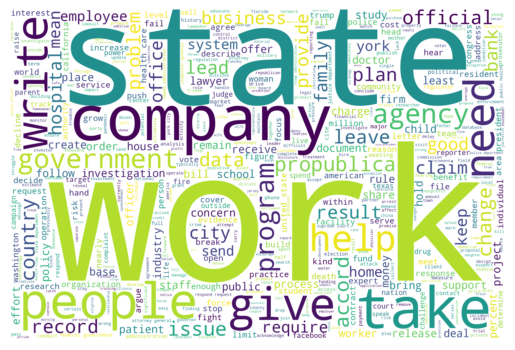

In [25]:
vc = visual(final_df["article_content_tokens"])

**Saving the preprocessed wordcloud and dataset**

In [26]:
vc.save_wordcloud("propublica_wordcloud_v2.png")

In [27]:
final_df.to_csv('preprocessed_propublica_v2.csv', index=False) #output to csv